# Overview

#### ------------------------------------------------------------------------------------------------------------------------
## Backend
### Step 1: Load initial datasets (button: Load Initial Datasets)
### Step 2: Pre-processing and Merge (button: Pre-process and merge datasets)
### Step 3: Load a prepared dataset (button: Load processed datasets)
### Step 4: Data analysis and visualisation (button: Conduct statical and correlational analysis)

#### ------------------------------------------------------------------------------------------------------------------------
## Frontend
### Step 1: Design GUI
### Step 2: Implement the backend’s functions into GUI

#### ------------------------------------------------------------------------------------------------------------------------
## Note
1) For the non-functional requirements, the prototype requires: 
- Codes for error handling must be implemented in each function.
- Codes for providing feedback against the user actions. 

2) For the technical requirements, the developer uses:
- Core Python from version 3.8.2 within Anaconda using the Jupyter notebook.
- The design where each function is executed step-by-step rather than concurrently.

#### ------------------------------------------------------------------------------------------------------------------------

In [1]:
# Check version
import sys
import platform
# Load CSVs
import pandas as pd 
# Manipulate and Store Data
import sqlite3
# Calculate Correlation Coefficient
import numpy as np
# Display Graphs
import matplotlib.pyplot as plt

In [2]:
print(sys.version)

3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Backend

## Step 1: Load initial datasets (button: Load Initial Datasets)

In [3]:
# Step 1-1: Define the function which loads a CSV file

# Function: load_csv
# Purpose:
# This function loads a CSV file into a Pandas DataFrame, ensuring proper error handling.
# It validates the file path, attempts to read the file, and reports success or failure.
def load_csv(file_path):
    """
    Load a CSV file into a Pandas DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Step 1-1: File loaded successfully: {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path {file_path}")
    except pd.errors.ParserError:
        print(f"Error: Failed to parse the file at {file_path}")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
    return None


# Step 1-2: Define the function to validate columns in the dataset

# Function: validate_columns
# Purpose:
# This function validates if a given DataFrame contains all the required columns.
# If required columns are missing, it raises an error with details about the missing columns.
def validate_columns(df, expected_columns, file_name):
    """
    Validate the presence of required columns in a DataFrame.
    """
    missing_columns = expected_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns {missing_columns} in {file_name}")


# Step 1-3: Load and validate all datasets

# Function: load_and_validate_datasets
# Purpose:
# This function loads and validates three datasets (USER_LOG, ACTIVITY_LOG, COMPONENT_CODES).
# It ensures the columns match the expected schema for each dataset.
def load_and_validate_datasets(user_path, activity_path, component_path):
    """
    Load and validate all required datasets (USER_LOG, ACTIVITY_LOG, COMPONENT_CODES).
    """
    try:
        # Define the expected columns for each dataset
        expected_columns_user_log = {"Date", "Time", "User Full Name *Anonymized"}
        expected_columns_activity_log = {"User Full Name *Anonymized", "Component", "Action", "Target"}
        expected_columns_component_codes = {"Component", "Code"}

        # Load datasets
        df_user = load_csv(user_path)
        df_activity = load_csv(activity_path)
        df_component = load_csv(component_path)

        # Validate columns
        validate_columns(df_user, expected_columns_user_log, "USER_LOG")
        validate_columns(df_activity, expected_columns_activity_log, "ACTIVITY_LOG")
        validate_columns(df_component, expected_columns_component_codes, "COMPONENT_CODES")

        # Rename "User Full Name" to "User_ID" for consistency
        df_user.rename(columns={"User Full Name *Anonymized": "User_ID"}, inplace=True)
        df_activity.rename(columns={"User Full Name *Anonymized": "User_ID"}, inplace=True)

        print("Step 1: All datasets loaded and validated successfully.")
        return df_user, df_activity, df_component

    except Exception as e:
        print(f"Error in Step 1: {str(e)}")
        return None, None, None

In [4]:
# Test: Load the uploaded CSV files
user_path = "Data/USER_LOG.csv"
activity_path = "Data/ACTIVITY_LOG.csv"
component_path = "Data/COMPONENT_CODES.csv"

# Test: Validate the loaded files
df_user, df_activity, df_component = load_and_validate_datasets(user_path, activity_path, component_path)
if df_user is not None and df_activity is not None and df_component is not None:
    print("Datasets are ready for the next step.")
else:
    print("Error in loading datasets. Check the logs above.")

Step 1-1: File loaded successfully: Data/USER_LOG.csv
Step 1-1: File loaded successfully: Data/ACTIVITY_LOG.csv
Step 1-1: File loaded successfully: Data/COMPONENT_CODES.csv
Step 1: All datasets loaded and validated successfully.
Datasets are ready for the next step.


## Step 2: Pre-processing and Merge (button: Pre-process and Merge Datasets)

In [5]:
# Step 2-1: Add the column which is a primary key in Pandas
# Purpose: Assign unique primary keys to the USER_LOG and ACTIVITY_LOG datasets for consistent identification.
def add_primary_keys():
    """
    Step 2-1: Add primary keys to USER_LOG and ACTIVITY_LOG datasets.
    """
    global df_user, df_activity
    df_user['PK'] = range(1, len(df_user) + 1)
    df_activity['PK'] = range(1, len(df_activity) + 1)
    print("Step 2-1: Primary keys added successfully.")

# Step 2-2: Extract Month Column in Pandas
def extract_month_column():
    """
    Step 2-2: Extract the Month column from the Date column in ACTIVITY_LOG.
    """
    global df_activity, df_user
    try:
        # Merge USER_LOG into ACTIVITY_LOG for Date and Time
        df_activity = pd.merge(
            df_activity, 
            df_user[['PK', 'Date', 'Time']], 
            on='PK', 
            how='left'
        )
        
        # Rename columns explicitly to avoid conflicts
        df_activity.rename(columns={"Date": "Activity_Date", "Time": "Activity_Time"}, inplace=True)
        
        # Combine Activity_Date and Activity_Time into a single datetime column
        df_activity['Activity_DateTime'] = pd.to_datetime(
            df_activity['Activity_Date'] + ' ' + df_activity['Activity_Time'], errors='coerce'
        )
        
        # Extract the Month from the combined datetime column
        df_activity['Month'] = df_activity['Activity_DateTime'].dt.strftime('%B')
        print("Step 2-2: Month column extracted successfully.")
    except Exception as e:
        print(f"Error in Step 2-2: {str(e)}")

# Step 2-3: Create SQLite Database Tables
# Function: create_sqlite_tables
# Purpose:
# Creates raw SQLite tables using the original column names, including "User Full Name *Anonymized".
# Ensures compatibility with Step 2-5 for renaming columns later.
def create_sqlite_tables(conn):
    """
    Step 2-3: Create SQLite tables for raw data storage.
    """
    cursor = conn.cursor()
    try:
        # Create USER_LOG table with original column names
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS USER_LOG (
                PK INTEGER PRIMARY KEY,
                "User Full Name *Anonymized" TEXT,
                Date TEXT,
                Time TEXT
            )
        ''')

        # Create COMPONENT_CODES table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS COMPONENT_CODES (
                Component TEXT,
                Code TEXT
            )
        ''')

        # Create ACTIVITY_LOG table with original column names
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS ACTIVITY_LOG (
                PK INTEGER PRIMARY KEY,
                "User Full Name *Anonymized" TEXT,
                Component TEXT,
                Action TEXT,
                Target TEXT,
                Activity_Date TEXT,
                Activity_Time TEXT,
                Month TEXT
            )
        ''')

        conn.commit()
        print("Step 2-3: SQLite tables created successfully with original column names.")
    except Exception as e:
        print(f"Error in Step 2-3: {str(e)}")

# Step 2-4: Store raw data in SQLite
# Function: store_raw_data
# Purpose:
# Saves the preprocessed Pandas DataFrames into SQLite tables for further cleaning and merging.
# Ensures that the column names match the original dataset format.
def store_raw_data(conn):
    """
    Step 2-4: Store raw data into SQLite tables.
    """
    global df_user, df_activity, df_component

    try:
        # Ensure correct column names before saving
        if "User_ID" in df_user.columns:
            df_user.rename(columns={"User_ID": "User Full Name *Anonymized"}, inplace=True)
        if "User_ID" in df_activity.columns:
            df_activity.rename(columns={"User_ID": "User Full Name *Anonymized"}, inplace=True)

        # Save to SQLite
        df_user.to_sql("USER_LOG", conn, if_exists="replace", index=False)
        df_component.to_sql("COMPONENT_CODES", conn, if_exists="replace", index=False)
        df_activity.to_sql("ACTIVITY_LOG", conn, if_exists="replace", index=False)

        print("Step 2-4: Raw data stored in SQLite successfully.")
    except Exception as e:
        print(f"Error in Step 2-4: {str(e)}")


# Step 2-5: Clean the datasets in SQLite (RENAME and REMOVE)
# Function: clean_datasets
# Purpose:
# This function cleans the datasets stored in SQLite by:
# - REMOVE: Deleting unnecessary rows (where Component is 'System' or 'Folder').
# - RENAME: Renaming "User Full Name *Anonymized" to "User_ID".
def clean_datasets(conn):
    """
    Step 2-5: Clean the datasets in SQLite (RENAME columns and REMOVE unnecessary rows).
    """
    cursor = conn.cursor()
    try:
        # Debugging: Show column names before renaming
        cursor.execute("PRAGMA table_info(USER_LOG)")
        user_log_columns = cursor.fetchall()
        cursor.execute("PRAGMA table_info(ACTIVITY_LOG)")
        activity_log_columns = cursor.fetchall()
        print("USER_LOG Columns:", user_log_columns)
        print("ACTIVITY_LOG Columns:", activity_log_columns)
        
        # REMOVE: Delete rows with unnecessary Component values
        cursor.execute('''
            DELETE FROM ACTIVITY_LOG WHERE Component IN ('System', 'Folder')
        ''')
        conn.commit()
        print("Step 2-5: Unnecessary rows removed successfully.")
        
        # RENAME: Standardize column "User Full Name *Anonymized" to "User_ID"
        cursor.execute('''
            ALTER TABLE USER_LOG RENAME COLUMN "User Full Name *Anonymized" TO "User_ID"
        ''')
        cursor.execute('''
            ALTER TABLE ACTIVITY_LOG RENAME COLUMN "User Full Name *Anonymized" TO "User_ID"
        ''')
        print("Step 2-5: Columns renamed successfully.")
    
    except Exception as e:
        print(f"Error in Step 2-5: {str(e)}")

# Step 2-6: Merge datasets in SQLite (MERGE)
# Purpose: Merge USER_LOG, COMPONENT_CODES, and ACTIVITY_LOG datasets into a single table for analysis.
def merge_datasets(conn):
    """
    Step 2-6: Merge USER_LOG, COMPONENT_CODES, and ACTIVITY_LOG datasets in SQLite.
    """
    cursor = conn.cursor()
    try:
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS MERGED_DATA AS
            SELECT 
                a.PK, 
                a.User_ID, 
                a.Component, 
                a.Action, 
                a.Target, 
                a.Activity_Date, 
                a.Activity_Time, 
                a.Month, 
                c.Code AS Component_Code
            FROM ACTIVITY_LOG a
            LEFT JOIN COMPONENT_CODES c ON a.Component = c.Component
            LEFT JOIN USER_LOG u ON a.User_ID = u.User_ID
        ''')
        conn.commit()
        print("Step 2-6: Datasets merged in SQLite successfully.")
    except Exception as e:
        print(f"Error in Step 2-6: {str(e)}")

# Step 2-7: Reshape data for Statistics in SQLite (RESHAPE) (COUNT)
# Purpose: Aggregate and reshape data for monthly and semester-wise statistics in SQLite.
def reshape_data_for_statistics(conn):
    """
    Step 2-7: Reshape data for statistics in SQLite.
    """
    cursor = conn.cursor()

    # Create monthly statistics table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS df1_statistics_monthly AS
        SELECT 
            User_ID, Month, 
            SUM(CASE WHEN Component = 'Quiz' THEN 1 ELSE 0 END) AS Quiz,
            SUM(CASE WHEN Component = 'Lecture' THEN 1 ELSE 0 END) AS Lecture,
            SUM(CASE WHEN Component = 'Assignment' THEN 1 ELSE 0 END) AS Assignment,
            SUM(CASE WHEN Component = 'Attendance' THEN 1 ELSE 0 END) AS Attendance,
            SUM(CASE WHEN Component = 'Survey' THEN 1 ELSE 0 END) AS Survey
        FROM MERGED_DATA
        GROUP BY User_ID, Month
    ''')

    # Create semester statistics table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS df2_statistics_semester AS
        SELECT 
            User_ID, 
            SUM(CASE WHEN Component = 'Quiz' THEN 1 ELSE 0 END) AS Quiz,
            SUM(CASE WHEN Component = 'Lecture' THEN 1 ELSE 0 END) AS Lecture,
            SUM(CASE WHEN Component = 'Assignment' THEN 1 ELSE 0 END) AS Assignment,
            SUM(CASE WHEN Component = 'Attendance' THEN 1 ELSE 0 END) AS Attendance,
            SUM(CASE WHEN Component = 'Survey' THEN 1 ELSE 0 END) AS Survey
        FROM MERGED_DATA
        GROUP BY User_ID
    ''')
    conn.commit()
    print("Step 2-7: Data reshaped for statistics in SQLite.")

In [6]:
# Main function for Step 2
def preprocess_and_merge():
    """
    Step 2: Preprocess and merge datasets using SQLite for cleaning, merging, and reshaping.
    """
    try:
        # Add primary keys and extract the month
        add_primary_keys()
        extract_month_column()

        # Open SQLite connection
        connection = sqlite3.connect("processed_data.db")

        # Create tables and store raw data
        create_sqlite_tables(connection)
        store_raw_data(connection)

        # Clean, merge, and reshape data
        clean_datasets(connection)
        merge_datasets(connection)
        reshape_data_for_statistics(connection)

        # Close SQLite connection
        connection.close()
        print("Step 2 Complete: Preprocessing and merging completed successfully.")
    except Exception as e:
        print(f"Error in Step 2: {str(e)}")

In [7]:
preprocess_and_merge()

Step 2-1: Primary keys added successfully.
Step 2-2: Month column extracted successfully.
Step 2-3: SQLite tables created successfully with original column names.
Step 2-4: Raw data stored in SQLite successfully.
USER_LOG Columns: [(0, 'Date', 'TEXT', 0, None, 0), (1, 'Time', 'TEXT', 0, None, 0), (2, 'User Full Name *Anonymized', 'INTEGER', 0, None, 0), (3, 'PK', 'INTEGER', 0, None, 0)]
ACTIVITY_LOG Columns: [(0, 'User Full Name *Anonymized', 'INTEGER', 0, None, 0), (1, 'Component', 'TEXT', 0, None, 0), (2, 'Action', 'TEXT', 0, None, 0), (3, 'Target', 'TEXT', 0, None, 0), (4, 'PK', 'INTEGER', 0, None, 0), (5, 'Activity_Date', 'TEXT', 0, None, 0), (6, 'Activity_Time', 'TEXT', 0, None, 0), (7, 'Activity_DateTime', 'TIMESTAMP', 0, None, 0), (8, 'Month', 'TEXT', 0, None, 0)]
Step 2-5: Unnecessary rows removed successfully.
Step 2-5: Columns renamed successfully.
Step 2-6: Datasets merged in SQLite successfully.
Step 2-7: Data reshaped for statistics in SQLite.
Step 2 Complete: Preprocessin

## Step 3: Load a prepared dataset (button: Load Processed Datasets)

In [8]:
# Step 3-1: Load the Processed Data

# Function: load_data
# Purpose:
# Loads data from a specified SQLite table into a Pandas DataFrame.
# Facilitates the retrieval of processed data for analysis or visualization.
def load_data(table_name, conn):
    """
    Load data from a SQLite table into a DataFrame.
    """
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, conn)
        print(f"Step 3-1: Data loaded from table '{table_name}' successfully.")
        return df
    except Exception as e:
        print(f"Step 3-1: Error while loading data from table '{table_name}': {str(e)}")
        return None

In [9]:
# Step 3-2: Close the SQLite Connection

# Function: close_connection
# Purpose:
# Safely closes the SQLite database connection to free up resources.
def close_connection(conn):
    """
    Close the SQLite connection.
    """
    try:
        conn.close()
        print("Step 3-2: Database connection closed successfully.")
    except Exception as e:
        print(f"Step 3-2: Error while closing connection: {str(e)}")

In [10]:
# Test: Load DataFrames from the SQLite database
connection = sqlite3.connect("processed_data.db") # Reopen the SQLite connection
loaded_df1 = load_data("df1_statistics_monthly", connection)  # Monthly statistics
loaded_df2 = load_data("df2_statistics_semester", connection)  # Semester statistics
loaded_interaction_counts = load_data("interaction_counts", connection)  # Interaction counts

Step 3-1: Data loaded from table 'df1_statistics_monthly' successfully.
Step 3-1: Data loaded from table 'df2_statistics_semester' successfully.
Step 3-1: Data loaded from table 'interaction_counts' successfully.


In [11]:
# Close the database connection
close_connection(connection)

Step 3-2: Database connection closed successfully.


## Step 4: Conduct Data analysis and visualisation 
## (button: Conduct statical and correlational analysis)

In [12]:
# Step 4-1: Conduct Monthly Statistics Analysis

def conduct_monthly_statistics(df):
    """
    Conducts monthly statistics analysis and returns the results in a table format.
    """
    try:
        # Define the components to analyze, keeping 'Attendence' for internal processing
        components = ['Quiz', 'Lecture', 'Assignment', 'Attendence', 'Survey']
        available_components = [col for col in components if col in df.columns]

        if len(available_components) == 0:
            raise ValueError("No components available for statistics.")

        # Calculate mean, median, and mode for each component
        statistics = {}
        for component in available_components:
            mean = round(df[component].mean(), 1)
            median = round(df[component].median(), 1)
            mode = round(df[component].mode().iloc[0], 1) if not df[component].mode().empty else None
            statistics[component] = {"Mean": mean, "Median": median, "Mode": mode}

        # Convert to DataFrame for table-like output
        stats_df = pd.DataFrame(statistics).T
        stats_df.index.name = "Component"

        # Rename "Attendence" to "Attendance" in the final output
        stats_df.rename(index={"Attendence": "Attendance"}, inplace=True)

        print("Step 4-1: Monthly statistics calculated successfully (Table Format).")
        return stats_df
    except Exception as e:
        print(f"Step 4-1: Error during statistics calculation: {str(e)}")
        return None

In [13]:
# Test: Monthly Statistics
monthly_stats_table = conduct_monthly_statistics(loaded_df1)
print("Monthly Statistics (Table Format):")
print(monthly_stats_table)

Step 4-1: Monthly statistics calculated successfully (Table Format).
Monthly Statistics (Table Format):
            Mean  Median  Mode
Component                     
Quiz        35.0     0.0   0.0
Lecture     13.5     2.0   0.0
Assignment  78.1    64.0   0.0
Attendance   0.9     0.0   0.0
Survey       2.3     0.0   0.0


In [14]:
# Step 4-2: Conduct Semester Statistics Analysis

def conduct_semester_statistics(df):
    """
    Conducts semester-wide statistics analysis and returns the results in a table format.
    """
    try:
        # Define the components to analyze, keeping 'Attendence' for internal processing
        components = ['Quiz', 'Lecture', 'Assignment', 'Attendence', 'Survey']
        available_components = [col for col in components if col in df.columns]

        if len(available_components) == 0:
            raise ValueError("No components available for statistics.")

        # Calculate mean, median, and mode for each component
        statistics = {}
        for component in available_components:
            mean = round(df[component].mean(), 1)
            median = round(df[component].median(), 1)
            mode = round(df[component].mode().iloc[0], 1) if not df[component].mode().empty else None
            statistics[component] = {"Mean": mean, "Median": median, "Mode": mode}

        # Convert to DataFrame for table-like output
        stats_df = pd.DataFrame(statistics).T
        stats_df.index.name = "Component"

        # Rename "Attendence" to "Attendance" in the final output
        stats_df.rename(index={"Attendence": "Attendance"}, inplace=True)

        print("Step 4-2: Semester statistics calculated successfully (Table Format).")
        return stats_df
    except Exception as e:
        print(f"Step 4-2: Error during statistics calculation: {str(e)}")
        return None

In [15]:
# Semester Statistics
semester_stats_table = conduct_semester_statistics(loaded_df2)
print("\nSemester Statistics (Table Format):")
print(semester_stats_table)

Step 4-2: Semester statistics calculated successfully (Table Format).

Semester Statistics (Table Format):
             Mean  Median   Mode
Component                       
Quiz        130.3   114.0    0.0
Lecture      50.3    50.5   72.0
Assignment  291.0   268.0  223.0
Attendance    3.4     1.0    0.0
Survey        8.6     8.0    6.0


In [16]:
# Step 4-3:  Display the user interaction for each component

# Function: plot_user_interaction_histogram
# Purpose:
# Plots a histogram for user interactions for each component.
def plot_user_interaction_histogram(df):
    """
    Plots a histogram of user interactions for each component.
    """
    try:
        components = ['Assignment', 'Quiz', 'Lecture', 'Book', 'Project', 'Course']
        available_components = [col for col in components if col in df.columns]

        if len(available_components) == 0:
            raise ValueError("No components found for histogram plotting.")

        # Plot histogram
        df[available_components].sum().plot(
            kind='bar',
            figsize=(10, 6),
            title="User Interaction Across Components",
            xlabel="Component",
            ylabel="Number of Interactions"
        )

        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
        print("Step 4-3: Histogram of user interactions generated successfully.")
    except Exception as e:
        print(f"Step 4-3: Error during histogram plotting: {str(e)}")

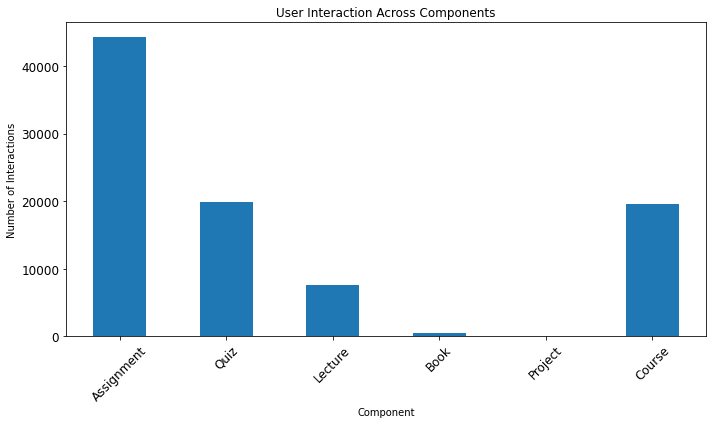

Step 4-3: Histogram of user interactions generated successfully.


In [17]:
# Test: Generate histogram of user interactions
plot_user_interaction_histogram(loaded_interaction_counts)

In [18]:
# Step 4-4: Scatter plots with regression line and correlation coefficient
def plot_user_component_scatter_with_regression(df):
    """
    Plots scatter plots for User_ID and each component, including regression line and correlation coefficient.
    Returns a list of matplotlib figures.
    """
    figures = []  # List to hold all figures
    try:
        components = ['Assignment', 'Quiz', 'Lecture', 'Book', 'Project', 'Course']
        available_components = [col for col in components if col in df.columns]

        if len(available_components) == 0:
            raise ValueError("No components found for scatter plot.")

        for component in available_components:
            # Calculate correlation coefficient
            correlation = df['User_ID'].corr(df[component])

            # Linear regression: Fit a line
            x = df['User_ID']
            y = df[component]
            coeffs = np.polyfit(x, y, 1)  # Linear regression
            regression_line = np.poly1d(coeffs)

            # Calculate outliers based on ±3 standard deviations
            mean = y.mean()
            std_dev = y.std()
            outliers = (y > mean + 3 * std_dev) | (y < mean - 3 * std_dev)

            # Create scatter plot
            fig, ax = plt.subplots(figsize=(8, 5))
            ax.scatter(x[~outliers], y[~outliers], alpha=0.6, label="Normal Data")
            ax.scatter(x[outliers], y[outliers], color='red', alpha=0.8, label="Outliers")
            ax.plot(x, regression_line(x), color="blue", label=f"y={coeffs[0]:.2f}x+{coeffs[1]:.2f}")

            # Title and labels
            ax.set_title(f"User_ID vs {component}\nCorrelation: {correlation:.2f}", fontsize=14)
            ax.set_xlabel("User_ID", fontsize=12)
            ax.set_ylabel(f"{component} Interactions", fontsize=12)
            ax.legend(fontsize=12)
            ax.grid(True, alpha=0.3)
            plt.tight_layout()

            # Append figure to the list
            figures.append(fig)

        return figures

    except Exception as e:
        print(f"Error in scatter plotting: {str(e)}")
        return figures  # Return any successfully created figures

In [20]:
# Step 4-4: Scatter plots with regression line and correlation coefficient
def calculate_correlation(x, y):
    """
    Calculate the Pearson correlation coefficient between two variables.
    """
    try:
        return x.corr(y)
    except Exception as e:
        print(f"Error calculating correlation: {str(e)}")
        return None


def calculate_regression_coefficients(x, y):
    """
    Perform linear regression and return coefficients.
    Returns [slope, intercept].
    """
    try:
        return np.polyfit(x, y, 1)  # Linear regression coefficients
    except Exception as e:
        print(f"Error calculating regression coefficients: {str(e)}")
        return None


def identify_outliers(y, threshold=3):
    """
    Identify outliers based on the threshold of standard deviations.
    Returns a boolean mask of outliers.
    """
    try:
        mean = y.mean()
        std_dev = y.std()
        return (y > mean + threshold * std_dev) | (y < mean - threshold * std_dev)
    except Exception as e:
        print(f"Error identifying outliers: {str(e)}")
        return None

[<Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>]

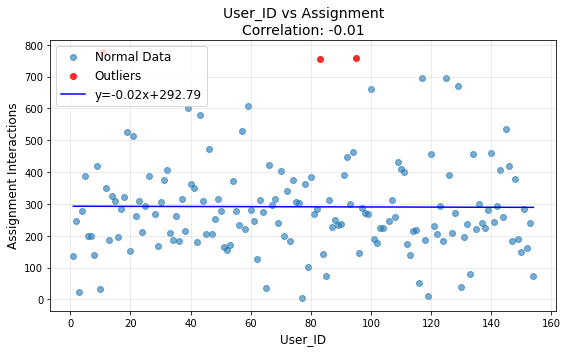

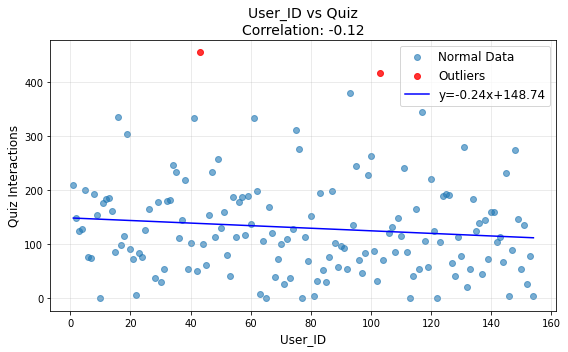

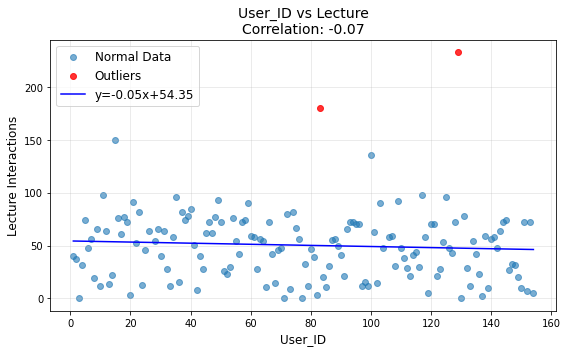

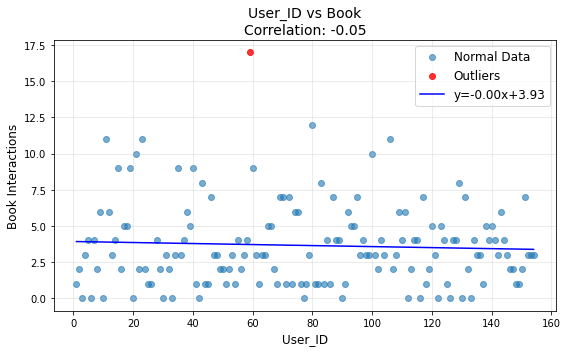

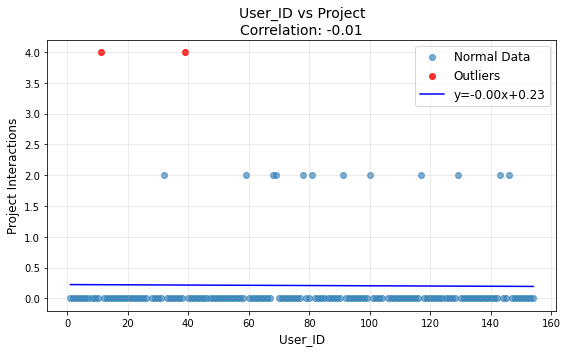

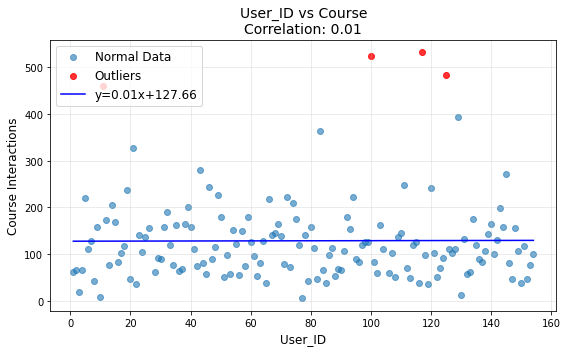

In [19]:
# Test: Generate scatter plots with regression lines and correlation coefficients
plot_user_component_scatter_with_regression(loaded_interaction_counts)

# EOF